# Quick Start Tutorial of the basic functionality of MetaDrive

Welcome to try out MetaDrive!

MetaDrive v0.2.5 supports two running modes:

1. **With 3D rendering functionality**: MetaDrive can easily install and run in personal computer, but may need special treatments for 3D rendering in headless machine and cloud servers.

2. **Without 3D rendering functionality**: MetaDrive can easily install and run in any machine. In this Colab notebook, we demonstrate MetaDrive in this mode and the renderer will be the **2D** **Pygame** renderer.

In this tutorial, we will navigate you through the installation and some basic functionality of MetaDrive!

## Installation

You can install MetaDrive easily.

In [ ]:
#@title Collect the MetaDrive

%pip install git+https://github.com/metadriverse/metadrive.git

In [1]:
# @title Test Installation
from metadrive import MetaDriveEnv
from metadrive.examples import expert

env = MetaDriveEnv()
print("\nThe action space: {}".format(env.action_space))
print("\nThe observation space: {}\n".format(env.observation_space))
try:
    env.reset()
    for i in range(100):
        env.step(env.action_space.sample())
    print("Successfully run MetaDrive")
except:
    print("Fail to run MetaDrive!")
finally:
    env.close()



[INFO] Successfully registered the following environments: ['MetaDrive-validation-v0', 'MetaDrive-10env-v0', 'MetaDrive-100envs-v0', 'MetaDrive-1000envs-v0', 'SafeMetaDrive-validation-v0', 'SafeMetaDrive-10env-v0', 'SafeMetaDrive-100envs-v0', 'SafeMetaDrive-1000envs-v0', 'MARLTollgate-v0', 'MARLBottleneck-v0', 'MARLRoundabout-v0', 'MARLIntersection-v0', 'MARLParkingLot-v0', 'MARLMetaDrive-v0'].
[INFO] MetaDrive version: 0.4.1.1
[INFO] Sensors: []
[INFO] Render Mode: none
[INFO] Assets version: 0.4.1.1



The action space: Box(-1.0, 1.0, (2,), float32)

The observation space: Box(-0.0, 1.0, (259,), float32)

Successfully run MetaDrive


## Basic Functionality

[INFO] MetaDrive version: 0.4.1.1
[INFO] Sensors: []
[INFO] Render Mode: none
[WARNING] environment_num is deprecated. Use num_scenarios instead! (MetaDriveEnv metadrive_env.py:119)
[INFO] Assets version: 0.4.1.1


Starting the environment ...



[INFO] Episode ended! Scenario Index: 1000 Reason: arrive_dest.


Arriving Destination: True

Episode reward:  293.33599122058973

The last returned information: {'overtake_vehicle_num': 0, 'velocity': 6.902283858450247, 'steering': -0.003573414136003109, 'acceleration': 0.11564104027340852, 'step_energy': 0.028719841751573102, 'episode_energy': 11.803677981676064, 'policy': 'EnvInputPolicy', 'action': [-0.003573414136003109, 0.11564104027340852], 'raw_action': (-0.003573414136003109, 0.11564104027340852), 'crash_vehicle': False, 'crash_object': False, 'crash_building': False, 'out_of_road': False, 'arrive_dest': True, 'max_step': False, 'env_seed': 1000, 'crash': False, 'step_reward': 0.7203150381052136, 'cost': 0, 'episode_reward': 293.33599122058973, 'episode_length': 361}

MetaDrive successfully run!

Generate gif...

Open gif...


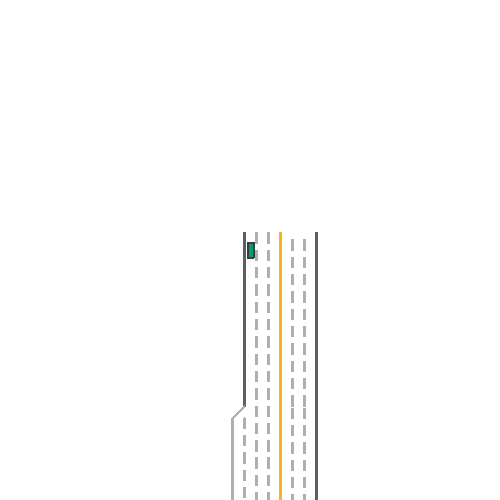

In [2]:
# @title A minimalist example of using MetaDrive with the built-in PPO expert policy

import os
os.environ['SDL_VIDEODRIVER']='dummy'
# Note: this step is only for cheating Colab

from metadrive import MetaDriveEnv
from metadrive.examples import expert

# Set the envrionment config
config = {"start_seed": 1000, 
          "num_scenarios":1,
          "traffic_density":0.1,
          }

env = MetaDriveEnv(config)

print("Starting the environment ...\n")

ep_reward = 0.0
obs, info = env.reset()
frames = []
for i in range(1000):
    obs, reward, terminated, truncated, info = env.step(expert(env.vehicle))
    ep_reward += reward
    frame = env.render(mode="top_down", film_size=(800, 800), track_target_vehicle=True, screen_size=(500, 500))
    frames.append(frame)
    if terminated or truncated:
        print("Arriving Destination: {}".format(info["arrive_dest"]))
        print("\nEpisode reward: ", ep_reward)
        break

print("\nThe last returned information: {}".format(info))

env.close()
print("\nMetaDrive successfully run!")

# render image
print("\nGenerate gif...")
import pygame
import numpy as np
from PIL import Image

imgs = [pygame.surfarray.array3d(frame) for frame in frames]
imgs = [Image.fromarray(img) for img in imgs]
imgs[0].save("demo.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)
print("\nOpen gif...")
from IPython.display import Image
Image(open("demo.gif", 'rb').read())


In [ ]:
# @title PPO expert policy can also drive in the safety-critical SafeMetaDrive environment
import os
os.environ['SDL_VIDEODRIVER']='dummy'
# Note: this step is only for cheating Colab

from metadrive import SafeMetaDriveEnv
from metadrive.examples import expert

# Set the environment config
config = {"start_seed": 0, 
          "num_scenarios":1,
          "accident_prob":1.0,
          "traffic_density":0.25,
          }

env = SafeMetaDriveEnv(config)

print("Starting the environment ...\n")

ep_reward = 0.0
ep_cost = 0.0
obs, info = env.reset()
frames = []
for i in range(1000):
    obs, reward, terminated, truncated, info = env.step(expert(env.vehicle))
    ep_reward += reward
    ep_cost += info["cost"]
    frame = env.render(mode="top_down", film_size=(1500, 1500), track_target_vehicle=True, screen_size=(500, 500))
    frames.append(frame)
    if terminated or truncated:
        print("Arriving Destination: {}".format(info["arrive_dest"]))
        print("\nEpisode reward: ", ep_reward)
        print("\nEpisode cost: ", ep_cost)
        break

env.close()
print("\nMetaDrive successfully run!")

# render image
print("\nGenerate gif...")
import pygame
import numpy as np
from PIL import Image

imgs = [pygame.surfarray.array3d(frame) for frame in frames]
imgs = [Image.fromarray(img) for img in imgs]
imgs[0].save("demo.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)
print("\nOpen gif...")
from IPython.display import Image
Image(open("demo.gif", 'rb').read())

[INFO] MetaDrive version: 0.4.1.1
[INFO] MetaDrive version: 0.4.1.1
[INFO] Sensors: []
[INFO] Sensors: []
[INFO] Render Mode: none
[INFO] Render Mode: none
[INFO] Assets version: 0.4.1.1


Starting the environment ...



In [ ]:
# @title Multi-agent Environment Visualization
import os
os.environ['SDL_VIDEODRIVER']='dummy'
# Note: this step is only for cheating Colab

from metadrive import MultiAgentRoundaboutEnv, MultiAgentBottleneckEnv, MultiAgentIntersectionEnv, MultiAgentParkingLotEnv, MultiAgentTollgateEnv
from metadrive.examples import expert

env_classes = [MultiAgentRoundaboutEnv, 
        MultiAgentBottleneckEnv, 
        MultiAgentIntersectionEnv, 
        MultiAgentParkingLotEnv, 
        MultiAgentTollgateEnv]

frames = []
for env_class in env_classes:
    env = env_class()
    print("Starting the environment {}\n".format(env))
    env.reset()
    tm={"__all__":False}
    for i in range(100):
        if tm["__all__"]:
            frames.append(frame)
            continue
        action = env.action_space.sample()
        for a in action.values(): 
            a[-1] = 1.0
        o,r,tm,tc,i = env.step(action)
        frame = env.render(mode="top_down", film_size=(500, 500), track_target_vehicle=False, screen_size=(500, 500))
        frames.append(frame)
    env.close()

# render image
print("\nGenerate gif...")
import pygame
import numpy as np
from PIL import Image

imgs = [pygame.surfarray.array3d(frame) for frame in frames]
imgs = [Image.fromarray(img) for img in imgs]
imgs[0].save("demo.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)
print("\nOpen gif...")
from IPython.display import Image
Image(open("demo.gif", 'rb').read())

## Map Generation

In [ ]:
# @title Draw the generated maps in top-down view

import random

import matplotlib.pyplot as plt
from metadrive import MetaDriveEnv
from metadrive.utils.draw_top_down_map import draw_top_down_map

env = MetaDriveEnv(config=dict(
    environment_num=100,
    map=7,
    start_seed=random.randint(0, 1000)
))

fig, axs = plt.subplots(4, 4, figsize=(10, 10), dpi=100)
for i in range(4):
    for j in range(4):
        env.reset()
        m = draw_top_down_map(env.current_map)
        ax = axs[i][j]
        ax.imshow(m, cmap="bone")
        ax.set_xticks([])
        ax.set_yticks([])
fig.suptitle("Bird's-eye view of generated maps")
plt.show()

env.close()


In [ ]:
# @title Draw the generated maps in top-down view with fixed block sequence
# @markdown You can also specify the road block sequence then randomize the block parameters.
# @markdown Please refer to [documentation](https://metadrive-simulator.readthedocs.io/en/latest/env_config.html#map-config) for the meaning of the map string.

import random

import matplotlib.pyplot as plt

from metadrive import MetaDriveEnv

env = MetaDriveEnv(config=dict(
    environment_num=100,
    map="CrTRXOS",
    start_seed=random.randint(0, 1000)
))

fig, axs = plt.subplots(4, 4, figsize=(10, 10), dpi=100)
for i in range(4):
    for j in range(4):
        env.reset()
        m = draw_top_down_map(env.current_map)
        ax = axs[i][j]
        ax = axs[i][j]
        ax.imshow(m, cmap="bone")
        ax.set_xticks([])
        ax.set_yticks([])
fig.suptitle("Bird's-eye view of generated maps")
plt.show()

env.close()
